In [1]:
import numpy as np 
%matplotlib inline
import matplotlib.pylab as plt

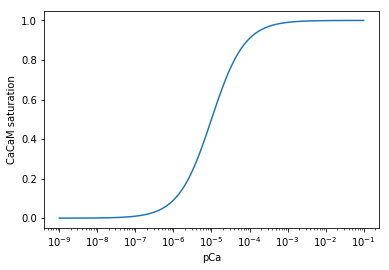

In [2]:
pCas = np.linspace(-9,-1,100)
pCas = 10**pCas
KD = 10**-5
CaBs = 1/ (1 + KD/pCas)

plt.plot(pCas,CaBs)
plt.xscale('log')
plt.xlabel("pCa")
plt.ylabel("CaCaM saturation")
plt.gcf().savefig("kca.png",dpi=300)

## SA 2 figure
${\frac {1}{x\sigma {\sqrt {2\pi }}}}\ e^{-{\frac {\left(\ln x-\mu \right)^{2}}{2\sigma ^{2}}}}$

In [3]:
# healthy
ts = np.linspace(0.1,1,100)
mu = 0.00
s = 3.


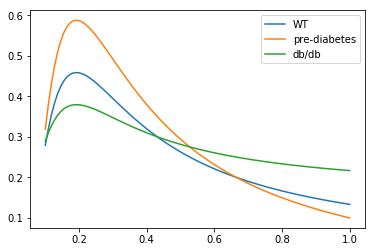

In [4]:
def func(t,mu,s,amp=1.,shift=0.):
    expon = np.log(t) - mu
    expon *= expon
    expon *= - expon/(2 * s*s)
    lhs = 1/(t *s *np.sqrt(2*np.pi))
    return amp*lhs * np.exp(expon) + shift

plt.plot(ts, func(ts,mu,s),label="WT")
plt.plot(ts, func(ts,mu,s,amp=1.5,shift=-0.1),label="pre-diabetes"  )
plt.plot(ts, func(ts,mu,s,amp=0.5,shift=0.15),label="db/db")
plt.legend(loc=0)
plt.gcf().savefig("test.png",dpi=300)

### Effective concentration

In [5]:
zeta = 0.35 #persistence length [nm] 
lenPerResi = 0.34 # [nm]
D = 53 *lenPerResi   # Residue between CaMBR C termimus (R414) and AID N-terminus (I467) is 52 a.a.
                     # thus the distance should be 3.4 x 53  
L = 8 * lenPerResi  # residue number between C-terminal of DH and N terminus of AID (DH is absorbed on CaM's surface)

def G_DZL(zeta,D,L):
    prefac = np.sqrt(3/(4*np.pi*zeta*L)) 
    prefac =prefac*prefac*prefac
    expon = -3*D*D/(4*zeta*L)
    return prefac * np.exp(expon)


Text(0,0.5,'P')

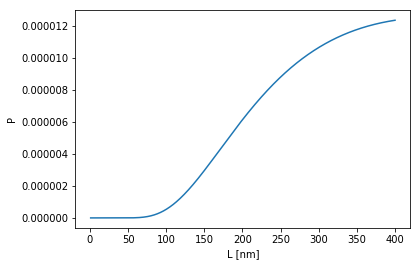

In [6]:
Ls = np.linspace(1,400,1000)
plt.plot(Ls, G_DZL(zeta,D,Ls))
#plt.plot(Ls, G_DZL(zeta*0.1,D,Ls))
plt.xlabel("L [nm]")
plt.ylabel("P")

### Concentration


In [7]:
nm3_to_L =1e-24

#### Check against water

In [8]:
V= 3.2e-1**3  # 1.4*~2
c = (1/6.022e23) / (V*nm3_to_L) # [mol/L]
print (c, " [M]")

50.67681521919627  [M]


#### Eff. conc for chained ligand 

In [9]:
# If 100 pct probability, G=1 in the volume that a binding site 'feels'
nm3_to_L =1e-24
Nsite_res = 5 # number of residues which define the volume of binding site
V_bs = (Nsite_res*.34) * (np.pi * (.34/2.)**2)  # num_res * 3.4 nm/res for height, area based on radius of aa/2 res
G = 1.
cLim = G/6.022e23 / (V_bs * nm3_to_L)
nm3_to_L =1e-24
print (cLim, " [M]")
print (V_bs)

10.758769719786205  [M]
0.1543464470708666


### Troponin C 

Text(0.5,0,'#/a.a.')

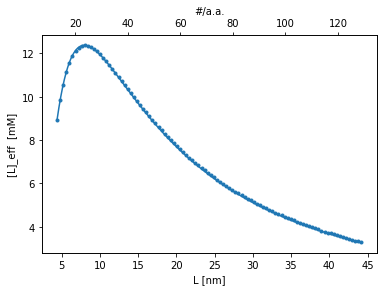

In [10]:
M_to_mM=1e3
M_to_uM=1e6
Ang_to_nm=1e-1
zeta = 1 # nm, persistense length
D = 40. *Ang_to_nm   # binding site distance [nm]
res = 13   # Residues 147-134 
Ang_per_res = 3.4 # [A]
Lmin = res*Ang_per_res * Ang_to_nm  # tether length [nm]
Lmax = Lmin * 10 
Ls = np.linspace(Lmin,Lmax,1000)
fig, ax1 = plt.subplots()
ax1.plot(Ls, G_DZL(zeta,D,Ls)* cLim*M_to_mM)
ax1.set_xlabel("L [nm]")
ax1.set_ylabel("[L]_eff  [mM]")
ax2 = ax1.twiny()
L_per_res = 3.4 # [nm]
ax2.plot(Ls[::10]/(L_per_res * Ang_to_nm), G_DZL(zeta,D,Ls)[::10]* cLim*M_to_mM,'.')
ax2.set_xlabel("#/a.a.")

#### Siddiqui2016 Estimate
I get close, but not same value; WLC estimate is within a factor of two

In [11]:
# Residues 134-147, 3.4 A/res
r=(147-134)*3.4
print (r*Ang_to_nm, " [nm]")
A3_to_L = 1e-27
V = 4/3. * np.pi*r**3  * A3_to_L # V [L]
print (V, " [L]")
conc = 1/6.022e23/V
print (conc* M_to_mM, " [mM]")


4.42  [nm]
3.6170575382900657e-22  [L]
4.590963410241044  [mM]


In [13]:
#===============================================
# Here we consider only two competetive events
# -- free AID and PRII substrate
#===============================================
# now read in the experimental data in fig 3 of AID titration in Biochem. J. (1996) 320, 879±884, SAGOO el al'
# 1) similar to the Pon definition in Van Valen's paper, we define a probability of CaN being activated by 
# the PRII substrate  as Pon = (1 + [PRII]/Kd1 )/(1 + [AID]/Kd2 + [PRII]/Kd1) where [PRII] = 15 uM and Kd1,Kd2 are
# dissociation constants  of [PRII] ppetide and [AID] respectively
# 2) By fitting Pon to experimental data, we got the value of Kd1 and Kd2

from scipy.optimize import curve_fit


def pf(x,kd1,kd2):
    return (1+15/kd1)/(1+x/kd2 + 15/kd1) # where x is AID concentration and 15 (uM) is PRII concentration



In [14]:
# read in experimental data
expt = np.loadtxt("/home/AD/bsu233/plotfigures/CaMDH/AID_titration/expt")
expt_AID = expt[:,0]
expt_Pf = expt[:,1]
expt_Pferror=expt[:,2]
(fit_kd1,fit_kd2),fit_cov = curve_fit(pf, expt_AID,expt_Pf)

/home/AD/bsu233/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


fit_kd1 and fit_kd2 are   12.577 uM and    0.565 uM, respectively


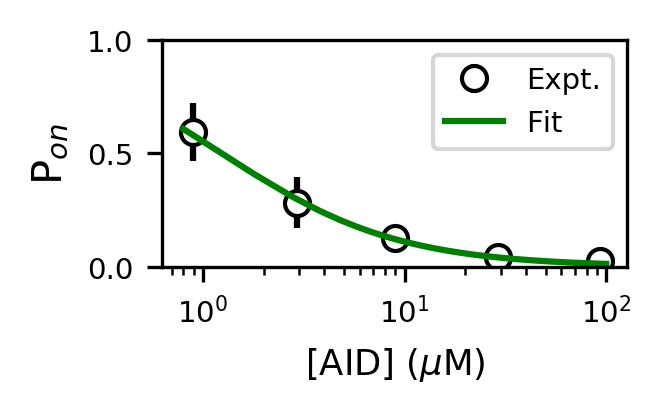

In [16]:
print ("fit_kd1 and fit_kd2 are %8.3f uM and %8.3f uM, respectively" % (fit_kd1,fit_kd2))
from matplotlib import rcParams
rcParams['figure.figsize'] = 2,1
rcParams['figure.dpi'] =300
nAID=np.linspace(0.8,100,100)
plt.errorbar(expt_AID,expt_Pf,yerr=expt_Pferror, fmt='o',color='black',mfc='white',label='Expt.')
plt.errorbar(nAID,pf(nAID,fit_kd1,fit_kd2),label='Fit',color='green')
plt.xscale('log')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel("[AID] ($\mu$M)",fontsize=8.5)
plt.ylim([0,1])
#ax1.tick_params(labelsize=8)
plt.ylabel("P$_{on}$")
plt.legend(fontsize=7)

In [38]:
# Read in data, panel (A) of fig3 in Fruman1995 paper
expt = np.loadtxt("/home/AD/bsu233/plotfigures/CaMDH/AID_titration/Fruman1995paper/expt")
expt_AID = expt[:,0]
expt_Pf = expt[:,1]

In [140]:
#===============================================================
# Here we consider THREE competetive events
# -- free AID peptide, tethered AID from intact CaN and PRII substrate
#==============================================================
# Known values from experiment: [pRII] = 5 uM
# Assumption: free AID and tethered AID have same dissociation constant 40 uM
# a) the probability of CaN being activated by PRII is:
# Pon = (1 + [PRII]/Kd1 )/(1 + [free-AID]/40 + [PRII]/Kd1 + [tethered-AID]/40) 
# b) Kd1 and [tethered-AID] are treated as unknown values
# c) By fitting Pon to experimental data, we got the value of Kd1 and [tethered-AID], the latter could
#    be used as effective concentration of 'CaM-bound + DH' in our model

def pf(x,tAID):
    return (1 + 5/10)/(1+5/10 + x/40 + tAID/40) # x is free-AID concentration

test


In [141]:
fit_tAID,fit_cov = curve_fit(pf, expt_AID,expt_Pf)

fitted tether-AID are    2.074 uM,
[[12.52889392]]


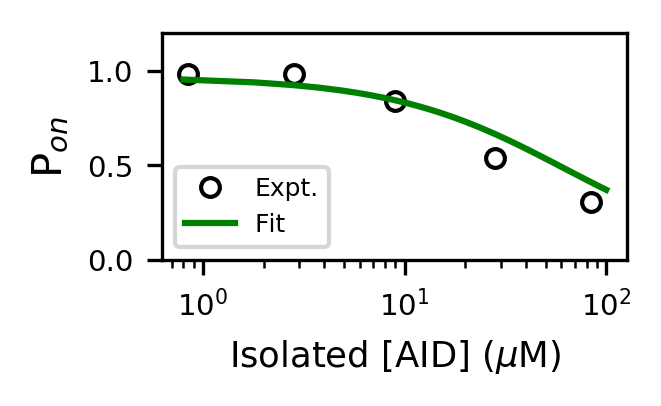

In [146]:
#print ("fit_kd1 and tether-AID are %8.3f uM and %8.3f uM, respectively" % (fit_kd1,fit_tAID))
print ("fitted tether-AID are %8.3f uM," % (fit_tAID))
print (fit_cov)
rcParams['figure.figsize'] = 2,1
rcParams['figure.dpi'] =300
plt.errorbar(expt_AID,expt_Pf, fmt='o',color='black',mfc='white',label='Expt.',ms=4.5)
#plt.errorbar(nAID,pf(nAID,fit_kd1,fit_tAID),label='Fit',color='green')
plt.errorbar(nAID,pf(nAID,fit_tAID),label='Fit',color='green')
plt.xscale('log')
plt.xticks(fontsize=7)
plt.yticks([0.0,0.5,1.0],fontsize=7)
plt.xlabel("Isolated [AID] ($\mu$M)",fontsize=8.5)
plt.ylim([0,1.2])

#ax1.tick_params(labelsize=8)
plt.ylabel("P$_{on}$")
plt.legend(fontsize=6)

Assume that C terminal of CaMBR domain is nearly completely extended in order to reach inhibitory domain on calcineurin, the residue number is 53

In [112]:
# distance between CaM and AID from our simulations
wtdata=np.loadtxt('/net/share/bsu233/CaMDH/pCaNtoAID/withCaM/wt/wtdis',comments='#')
a454edata=np.loadtxt('/net/share/bsu233/CaMDH/pCaNtoAID/withCaM/a454e/a454edis',comments='#')

print (np.mean(wtdata[:,1]),np.std(wtdata[:,1]),len(wtdata[:,1]))
print (np.mean(a454edata[:,1]),np.std(a454edata[:,1]),len(a454edata[:,1]))

23.426738590909093 2.820036425820002 6600
40.32714828333334 3.93244684526361 6000


Text(0,0.5,'AID-CaM dist.($\\AA$)')

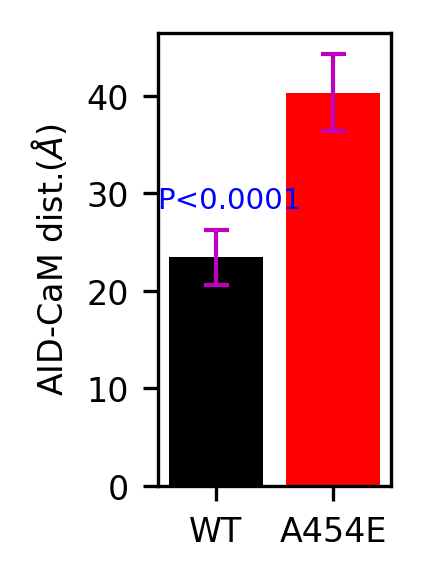

In [144]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 1,2
rcParams['figure.dpi'] =300

#P value of a454e with null hypothesis of being equal to WT 

width=0.8
plt.bar(0,np.mean(wtdata[:,1]),width,yerr=np.std(wtdata[:,1]),color="black",error_kw=dict(ecolor='m',lw=1,capsize=3,capthick=1))
plt.bar(1,np.mean(a454edata[:,1]),width,yerr=np.std(a454edata[:,1]),color='red',error_kw=dict(ecolor='m',lw=1,capsize=3,capthick=1))
plt.text(-0.5,np.mean(wtdata[:,1])+5,"P<0.0001",fontsize=7,color='blue')
plt.xticks([0,1],['WT','A454E'],fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel("AID-CaM dist.($\AA$)",fontsize=8)

# we commented out the following code regarding using 
# binding site volume to assess the unit of effective concentration

If 100 pct probability, G=1 in the volume that a binding site 'feels'

nm3_to_L =1e-24

Nsite_res = 5 # number of residues which define the volume of binding site

V_bs = (Nsite_res*.34) * (np.pi * (.34/2.)**2)  # num_res * 3.4 nm/res for height, area based on radius of aa/2 res

G = 1. 

cLim = G/6.022e23 / (V_bs * nm3_to_L)

print (cLim, " [M]")



In [114]:
D = 66 * Ang_to_nm # Measured between Ca.387 to Ca.481 in pdb 4or9
print (D, " [nm]")
L_free = 95 * Ang_per_res * Ang_to_nm # when No CaM, the tehter length is  a.a. resid 387 to resid 481
print (L_free, " [nm]")


L_CaM =  4.0 #nm, from Fig 11
print (L_CaM, " [nm]")

#simlarity, when CaM is bound and DH interaction is formed, our simulated data shows that:
L_CaMDH =  2.3 # nm
print (L_CaMDH, " [nm]")


6.6000000000000005  [nm]
32.300000000000004  [nm]
4.0  [nm]
2.3  [nm]


In [115]:
## We will use the Kd2= 0.565 uM of AID from experimnts as the reference unit
tether_length = np.array([L_free,L_CaM,L_CaMDH])
conc = G_DZL(zeta,D,tether_length)

#reference point
ref_conc = conc[2]
ref_unit = fit_tAID

effective_conc = (conc/ref_conc)*ref_unit

#

3.2018236133900992 2.0736840955698677 6.763439301735058


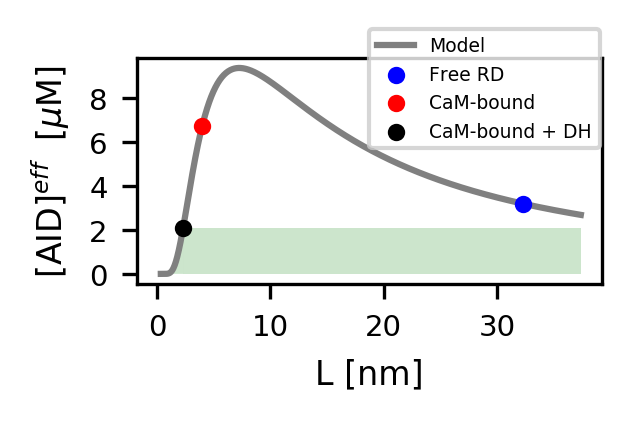

In [137]:
rcParams['figure.figsize'] = 2,1
rcParams['figure.dpi'] =300

res = 1
Lmin = res*Ang_per_res * Ang_to_nm  # tether length [nm]
res = 110
Lmax = res*Ang_per_res * Ang_to_nm  # tether length [nm] 
Ls = np.linspace(Lmin,Lmax,1000)

L_per_res = 0.34 #nm 
zeta=3

fig, ax1 = plt.subplots()
y = (G_DZL(zeta,D,Ls)/ref_conc)*ref_unit
ax1.plot(Ls, y,'grey',label='Model')


ax1.scatter(tether_length[0],effective_conc[0],color='blue',s=10,zorder=3,label='Free RD')
ax1.scatter(tether_length[1],effective_conc[1],color='red',s=10,zorder=3,label='CaMBR-bound')
ax1.scatter(tether_length[2],effective_conc[2],color='black',s=10,zorder=3,label='CaM-bound + DH')
ax1.set_xlabel("L [nm]",fontsize=8)
ax1.legend(fontsize=4.5,loc=(0.5,0.6), ncol=1)

#ax2.tick_params(labelsize=8)
ax1.tick_params(labelsize=7)
ax1.set_ylabel("[AID]$^{eff}$  [$\mu$M]",fontsize=8)
ax1.set_yticks([0,2,4,6,8,10])
# Now shade the aera wher the linker length is suffcient to release AID
x1x2 = np.linspace(0.1,tether_length[2],5)
x3x4 = np.linspace(tether_length[2],37.4,5)
#x3x4 = np.linspace(tether_length[0],20.4,100)
ylimit1 = effective_conc[2]
ylimit2 = (G_DZL(zeta,D,x1x2)/ref_conc)*ref_unit

ax1.fill_between(x1x2,0,ylimit2,edgecolor='none',facecolor='green', alpha='0.2')
ax1.fill_between(x3x4, 0,effective_conc[2],edgecolor='none',facecolor='green', alpha='0.2')
#ax1.set_ylim([0,3])

print (effective_conc[0],effective_conc[2],effective_conc[1])
#ax1.set_xlim([0,60])
#plt.gcf().savefig("CN_AID_tether.png")

Here we assume that 
1. CN inhibition is based on the free AID concentration
2. the free AID concentration is determined by the 'tether' length
3. the tether length can assume two values, short versus long. 
4. The relative proportion of short versus long is determined by the probability of DH-binding to CaM. We assume DH binding is independent of AID 

$$
\begin{align}
[CaMN_{Ca,DH}]&={{1}\over{\left({\it K_{D_{Ca}}/[Ca]}+1\right)\,{\it K_{D_{DH}}/[DH]}+1}}\\
[CN_{AID}]&={{1}\over{{\it K_{D_{AID}}/[AID]}+1}} \\
[AID]_{eff} &= pCaMDH\cdot[AID]_{eff,CaM} + (1-pCaMDH)\cdot[AID]_{eff,free}
\end{align}$$


In [34]:
cas = 10**np.linspace(-10,-4,101)

def exprCaM(ca,KDDH = 1e-3 # [M]
        ):
    
    KDCa = 1e-6 # [M]
    dh = 1e-3 # [M] - I don't think we need to fiddle with this concentration
    denom = KDCa/ca + 1
    denom = denom *(KDDH/dh)
    denom = denom + 1 
    return 1/denom
  
def exprCNInact(
      pCaMDH,# in [0,1]
      AIDeff_pCaMDH=0.01e-3, # [M] 
      AIDeff_free=2e-3):
    
    KDAID = 5e-4 # [M]
    #AID_eff = AIDeff_pCaMDH*pCaMDH
    #AID_eff += - AIDeff_pCaMDH*(1-pCaMDH)
    AID_eff = AIDeff_pCaMDH*pCaMDH + AIDeff_free*(1-pCaMDH)
    denom = KDAID/AID_eff + 1
    return 1/denom    

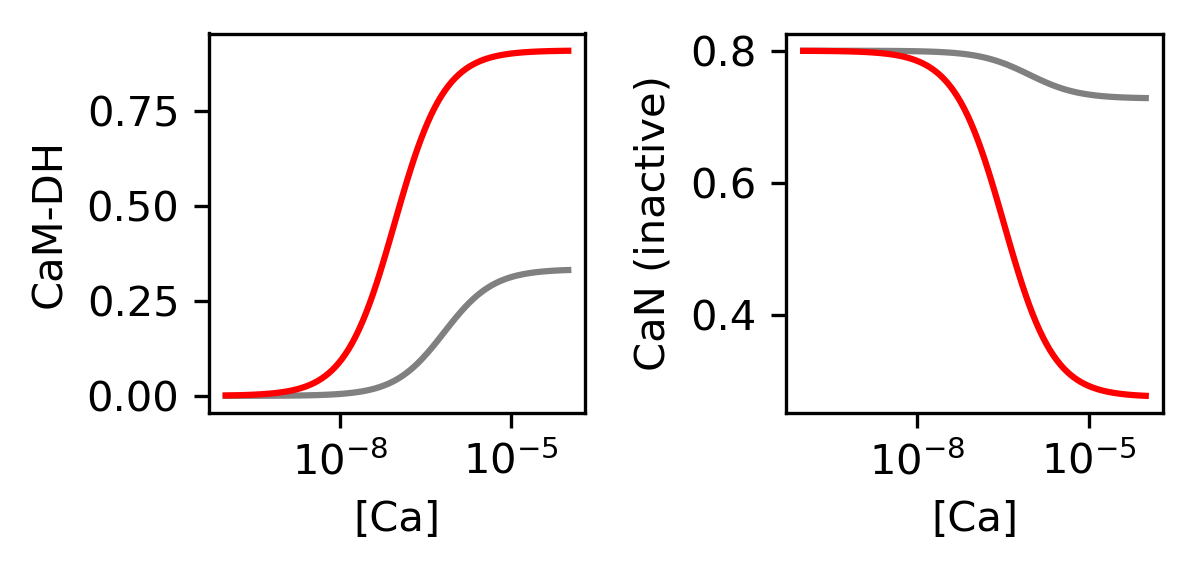

In [35]:
# Determine CaMDH 
plt.subplot(121)
camWeak = exprCaM(cas,KDDH=2e-3)
plt.plot(cas,camWeak,'gray',label='weak binding')
camStrong = exprCaM(cas,KDDH=0.1e-3)
plt.plot(cas,camStrong,'red',label='strong binding')
plt.xscale('log')
plt.ylabel("CaM-DH")
plt.xlabel("[Ca]")

if 1: 
    plt.subplot(122)
    plt.plot(cas,exprCNInact(camWeak),'gray',label='weak binding')
    plt.plot(cas,exprCNInact(camStrong),'red',label='strong binding')
    plt.xscale('log')
    plt.ylabel("CaN (inactive)")
    plt.xlabel("[Ca]")

else: 
    plt.subplot(122)
    plt.plot(cas,1-exprCNInact(camWeak),'gray',label='weak binding')
    plt.plot(cas,1-exprCNInact(camStrong),'red',label='strong binding')
    plt.xscale('log')
    plt.ylabel("CaN (active)")
    plt.xlabel("[Ca]")



plt.tight_layout()


In [46]:
# Now compute the enhancement relative to free pepetide
# For free peptide, GDZ = V_bs/V_box, we need to adjust V_box so that GDZ*cLim = 1 nM = 1e-9 [M]
V_box = 1660577881.1026237 # nm3
GDZ_free_peptide = V_bs/V_box

free_peptide_conc = GDZ_free_peptide/6.022e23 / (V_bs * nm3_to_L)

print (free_peptide_conc,"[M]")


1e-09 [M]


32.300000000000004
939119.6081029205 608227.5697563743 1983769.0121062426


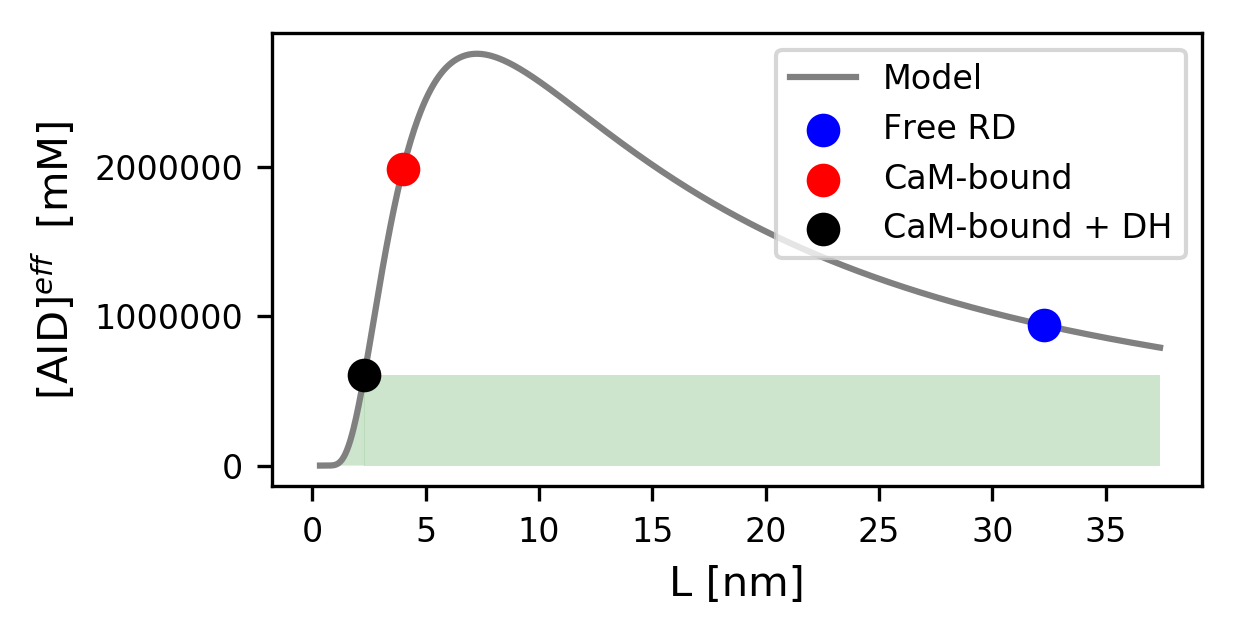

In [45]:
rcParams['figure.figsize'] = 4,2
rcParams['figure.dpi'] =300


res = 1
Lmin = res*Ang_per_res * Ang_to_nm  # tether length [nm]
res = 110
Lmax = res*Ang_per_res * Ang_to_nm  # tether length [nm] 
Ls = np.linspace(Lmin,Lmax,1000)

L_per_res = 0.34 #nm 
zeta=3

fig, ax1 = plt.subplots()
y = G_DZL(zeta,D,Ls)/GDZ_free_peptide
ax1.plot(Ls, y,'grey',label='Model')
tether_length = np.array([L_free,L_CaM,L_CaMDH])
print (tether_length[0])
conc = G_DZL(zeta,D,tether_length)/GDZ_free_peptide
ax1.scatter(tether_length[0],conc[0],color='blue',s=50,zorder=3,label='Free RD')
ax1.scatter(tether_length[1],conc[1],color='red',s=50,zorder=3,label='CaM-bound')
ax1.scatter(tether_length[2],conc[2],color='black',s=50,zorder=3,label='CaM-bound + DH')
ax1.set_xlabel("L [nm]")
ax1.legend(fontsize=8)

#ax2.tick_params(labelsize=8)
ax1.tick_params(labelsize=8)
ax1.set_ylabel("[AID]$^{eff}$  [mM]")

# Now shade the aera wher the linker length is suffcient to release AID
x1x2 = np.linspace(0.1,tether_length[2],5)
x3x4 = np.linspace(tether_length[2],37.4,5)
#x3x4 = np.linspace(tether_length[0],20.4,100)
ylimit1 = conc[2]
ylimit2 = G_DZL(zeta,D,x1x2)/GDZ_free_peptide

ax1.fill_between(x1x2,0,ylimit2,edgecolor='none',facecolor='green', alpha='0.2')
ax1.fill_between(x3x4, 0,conc[2],edgecolor='none',facecolor='green', alpha='0.2')
#ax1.set_ylim([0,3])

print (conc[0],conc[2],conc[1])